In [1]:
import numpy as np
import tensorflow as tf

import tensorflow.contrib.slim as slim
from tensorflow.python import pywrap_tensorflow


In [2]:
def get_variables_from_checkpoint_file(file_name):
    variables = []
    reader = pywrap_tensorflow.NewCheckpointReader(file_name)

    var_to_shape_map = reader.get_variable_to_shape_map()
    for key in sorted(var_to_shape_map):
        variables.append((key, var_to_shape_map[key]))

    return variables

In [3]:
from os import listdir
from os.path import isfile, join
import ntpath

data_dir = '/home/scpark/ai/datasets/waveglow-datasets/LJSpeech'
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.npz' in f]
print(len(data_files))


13090


In [4]:
BATCH_AXIS = 0
TIME_AXIS = 1
CHANNEL_AXIS = 2


In [5]:
def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])


def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])


def causal_conv(value, filter_, dilation, name='causal_conv'):
    with tf.name_scope(name):
        filter_width = tf.shape(filter_)[0]
        if dilation > 1:
            transformed = time_to_batch(value, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1,
                                padding='VALID')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(value, filter_, stride=1, padding='VALID')
        # Remove excess elements at the end.
        out_width = tf.shape(value)[1] - (filter_width - 1) * dilation
        result = tf.slice(restored,
                          [0, 0, 0],
                          [-1, out_width, -1])
        return result
    

In [6]:
def conv1d(inputs, filters, kernel_size=1, dilation_rate=1, zero_init=False, name='conv1d', reuse=False, freeze=False):
    
    with tf.variable_scope(name, reuse=reuse):
        
        #x = inputs[:, None, :, :]
        x = tf.expand_dims(inputs, axis=1)
        
        V_initializer = tf.constant_initializer(0.) if zero_init else tf.random_normal_initializer(0, 0.05)
        V = tf.get_variable('V', [1, kernel_size, int(inputs.get_shape()[-1]), filters], tf.float32, 
                            initializer=V_initializer, trainable=True)
        g = tf.get_variable('g', [filters], dtype=tf.float32, initializer=tf.constant_initializer(1.), trainable=True)
        b = tf.get_variable('b', [filters], dtype=tf.float32, initializer=tf.constant_initializer(0.), trainable=True)
        
        # use weight normalization (Salimans & Kingma, 2016)
        W = tf.reshape(g, [1, 1, 1, filters]) * tf.nn.l2_normalize(V, [0, 1, 2])
        
        W_normed = tf.get_variable('W_norm', [1, kernel_size, int(inputs.get_shape()[-1]), filters], tf.float32, trainable=False)
        
        # calculate convolutional layer output
        if not freeze:
            W_normed_assign = tf.assign(W_normed, W)
            tf.add_to_collection("freeze_assign", W_normed_assign)        
            x = tf.nn.bias_add(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID', dilations=[1, 1, dilation_rate, 1]), b)
            return x[:, 0, :, :]
        else:
            x = tf.nn.bias_add(tf.nn.conv2d(x, W_normed, strides=[1, 1, 1, 1], padding='VALID', dilations=[1, 1, dilation_rate, 1]), b)
            #x = tf.nn.bias_add(causal_conv(x[:, 0, :, :], W_normed[0, :, :, :], dilation_rate), b) 
            #x = tf.layers.dense(inputs, filters)
            
            return tf.squeeze(x, axis=1)

In [7]:
from tensorflow.contrib.framework.python.ops import add_arg_scope

# Invertible 1x1 conv
@add_arg_scope
def invertible_1x1_conv(name, z, c, reverse=False, freeze=False):

    if True:  # Set to "False" to use the LU-decomposed version

        with tf.variable_scope(name):

            shape = tf.shape(z)
            w_shape = [c, c]

            # Sample a random orthogonal matrix:
            w_init = np.linalg.qr(np.random.randn(
                *w_shape))[0].astype('float32')
            
            if np.linalg.det(w_init) < 0:
                w_init[:, 0] = -1. * w_init[:, 0]

            w = tf.get_variable("W", dtype=tf.float32, initializer=w_init)

            if not reverse:
                dlogdet = tf.cast(tf.log(abs(tf.matrix_determinant(
                    tf.cast(w, 'float64')))), 'float32') * tf.cast(shape[0] * shape[1] * shape[2], tf.float32)
            else:
                dlogdet = None
            
            w_inversed = tf.get_variable("W_inversed", dtype=tf.float32, initializer=w_init, trainable=False)
            
            if not reverse:

                _w = tf.reshape(w, [1, 1] + w_shape)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')

                return z, dlogdet
            
            else:
                if not freeze:
                    _w = tf.matrix_inverse(w)
                    
                    W_reverse_assign = tf.assign(w_inversed, tf.matrix_inverse(w))
                    tf.add_to_collection("freeze_assign", W_reverse_assign)
                    
                else:
                    _w = w_inversed
                    
                _w = tf.expand_dims(tf.expand_dims(_w, axis=0), axis=0)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                'SAME', data_format='NHWC')
                return z, dlogdet

            
def Invertible1x1Conv(z, c, reverse=False, name='inv1x1conv', reuse=False, freeze=False):
    
    with tf.variable_scope(name, reuse=reuse):
    
        z = tf.expand_dims(z, axis=1)
        z, logdet = invertible_1x1_conv(name, z, c, reverse=reverse, freeze=freeze)
        z = tf.squeeze(z, axis=1)
        
        if reverse:
            return z
        else:
            return z, logdet    
        

In [8]:
def fused_add_tanh_sigmoid_multiply(input_a, input_b, n_channels):
    in_act = input_a + input_b
    t_act = tf.tanh(in_act[:, :, :n_channels])
    s_act = tf.sigmoid(in_act[:, :, n_channels:])
    acts = t_act * s_act
    
    return acts


In [9]:
def WN(audio, spect, n_channels, n_layers, kernel_size, name='wavenet', reuse=False, freeze=False):
    
    with tf.variable_scope(name, reuse=reuse):
        n_in_channels = int(audio.get_shape()[-1])
        
        audio = conv1d(audio, n_channels, name='start', reuse=reuse, freeze=freeze)
    
        for i in range(n_layers):
            
            with tf.variable_scope(str(i), reuse=tf.AUTO_REUSE):
                
                dilation = 2 ** i
                padding = int((kernel_size * dilation - dilation) / 2)
                #padding = 0
                audio_padded = tf.pad(audio, [[0, 0], [padding, padding], [0, 0]])
                
                in_acts = conv1d(audio_padded, 2 * n_channels, kernel_size, dilation, name='in_layer', reuse=reuse, freeze=freeze)
                cond_acts = conv1d(spect, 2 * n_channels, name='cond_layer', reuse=reuse, freeze=freeze)
                acts = fused_add_tanh_sigmoid_multiply(in_acts, cond_acts, n_channels)
                
                res_skip_channels = 2 * n_channels if i < n_layers - 1 else n_channels
                res_skip_acts = conv1d(acts, res_skip_channels, name='res_skip_layer', reuse=reuse, freeze=freeze)
                
                if i < n_layers - 1:
                    audio = res_skip_acts[:, :, :n_channels] + audio
                    skip_acts = res_skip_acts[:, :, n_channels:]
                else:
                    skip_acts = res_skip_acts
                    
                if i == 0:
                    output = skip_acts
                else:
                    output = skip_acts + output

        # Zero Initialization
        # Glow : Generative Flow with Invertible 1x1 Convolutions
        output = tf.layers.conv1d(output, filters=2 * n_in_channels,
                                kernel_size=1, 
                                kernel_initializer=tf.zeros_initializer(), 
                                bias_initializer=tf.zeros_initializer(), reuse=reuse)
#        output = tf.layers.dense(output, 2 * n_in_channels, reuse=reuse)
        output_a, output_b = tf.split(output, num_or_size_splits=2, axis=CHANNEL_AXIS)
        
        return output_a, output_b
                
        

In [10]:
def upsample(spect, n_mel_channels, kernel_size, stride, name='upsample', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        # spect : [Batch, Time, n_mel_channels]
        
        # expand height
        #upsampled_spect = spect[:, None, :, :]
        upsampled_spect = tf.expand_dims(spect, axis=1)
        upsampled_spect = tf.layers.conv2d_transpose(inputs=upsampled_spect, 
                                                     filters=n_mel_channels, 
                                                     kernel_size=(1, kernel_size), 
                                                     strides=(1, stride),
                                                     padding='SAME')
        #upsampled_spect = upsampled_spect[:, 0, :, :]
        upsampled_spect = tf.squeeze(upsampled_spect, axis=1)

#         filter = tf.Variable(tf.random_normal([kernel_size, n_mel_channels, n_mel_channels]))        
#         upsampled_spect = tf.contrib.nn.conv1d_transpose(spect, filter=filter, 
#                                                          output_shape=[tf.shape(spect)[0], 32 * 256, 80], stride=stride, padding='SAME')
    
    return upsampled_spect



In [11]:
def waveGlowInverse(spect, n_mel_channels, n_flows, n_group, n_early_every, n_early_size, n_remaining_channels,
                    WN_n_channels, WN_n_layers, WN_kernel_size,
                    sigma=1.0, name='WaveGlow', reuse=True, freeze=False):
    
    with tf.variable_scope(name, reuse=reuse):
        
        # spect : [Batch, Time / 256, n_mel_channels]
        
        time_cutoff = 1024 - 256
        spect = upsample(spect, n_mel_channels, 1024, 256, reuse=reuse)
        #spect = spect[:, :-time_cutoff]
        Batch = tf.shape(spect)[0]
        
        spect = tf.reshape(spect, [Batch, -1, n_mel_channels * n_group])
        Time = tf.shape(spect)[1]

        #audio = tf.random_normal(shape=[Batch, Time, n_remaining_channels], stddev=sigma, dtype=tf.float32)
        audio = tf.get_variable('audio', dtype=tf.float32, initializer=np.random.randn(1, 1024, n_remaining_channels).astype('float32'))
        
        for k in reversed(range(n_flows)):
            
            with tf.variable_scope('flow_' + str(k), reuse=reuse):
                
                print('inverse flow ', k)
                
                audio_0, audio_1 = tf.split(audio, 2, axis=CHANNEL_AXIS)
                log_s, b = WN(audio_0, spect, 
                            n_channels=WN_n_channels, n_layers=WN_n_layers, kernel_size=WN_kernel_size, freeze=freeze)
                audio_1 = (audio_1 - b) / tf.exp(log_s)
                audio = tf.concat([audio_0, audio_1], axis=CHANNEL_AXIS)
                
                audio = Invertible1x1Conv(audio, n_remaining_channels, reverse=True, freeze=freeze)
                
                if k % n_early_every == 0 and k > 0:
                    #z = tf.random_normal(shape=[Batch, Time, n_early_size], dtype=tf.float32)
                    z = tf.get_variable('z', dtype=tf.float32, initializer=np.random.randn(1, 1024, n_early_size).astype('float32'))
                    audio = tf.concat([sigma * z, audio], axis=CHANNEL_AXIS)
                    n_remaining_channels = n_remaining_channels + n_early_size
        
        audio = tf.reshape(audio, [Batch, -1])
        
        return audio
    
def waveGlowLoss(z, log_s_list, log_det_W_list, sigma=1.0):
    
    log_s_total = 0
    log_det_W_total = 0
    
    for i, log_s in enumerate(log_s_list):
        log_s_total += tf.reduce_sum(log_s)
        log_det_W_total += log_det_W_list[i]
        
    nll_loss = tf.reduce_sum(z * z) / (2. * sigma * sigma) 
    det_loss = -log_s_total - log_det_W_total
    norm_factor = tf.cast(tf.shape(z)[0] * tf.shape(z)[1] * tf.shape(z)[2], tf.float32)
    loss = (nll_loss + det_loss) / norm_factor
    
    return nll_loss, det_loss, loss
            

In [12]:
tf.reset_default_graph()
Batch = 1
Time = 32
n_mel_channels = 80
n_flows = 12
n_group = 8
n_early_every = 4
n_early_size = 2

WN_n_layers = 8
WN_n_channels = 512
WN_kernel_size = 3

n_remaining_channels = 4

spect = tf.placeholder(dtype=tf.float32, shape=[Batch, Time, n_mel_channels])    
#spect_upsampled = upsample(spect, n_mel_channels, 1024, 256)

audio_sample = waveGlowInverse(spect, n_mel_channels, n_flows, n_group, n_early_every, n_early_size, n_remaining_channels,
                                 WN_n_channels, WN_n_layers, WN_kernel_size, reuse=False, freeze=True)
print(audio_sample)

freeze_collection = tf.get_collection('freeze_assign')
print(freeze_collection)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# print('converting')
# converter = tf.contrib.lite.TFLiteConverter.from_session(sess, [spect], [audio_sample])
# tflite_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)
# print('converted')

print('done')


inverse flow  11
inverse flow  10
inverse flow  9
inverse flow  8
inverse flow  7
inverse flow  6
inverse flow  5
inverse flow  4
inverse flow  3
inverse flow  2
inverse flow  1
inverse flow  0
Tensor("WaveGlow/Reshape_1:0", shape=(1, 8192), dtype=float32)
[]
done


In [27]:
load_dir = 'save/waveglow_LJ'
save_dir = 'save/waveglow_LJ'

if True:
    #Restore variables from disk.
    restore_path = tf.train.latest_checkpoint(load_dir)
    saved_variables = get_variables_from_checkpoint_file(restore_path)
    model_variables = slim.get_variables_to_restore()
    restore_variables = []

    for model_variable in model_variables:
        loaded = False
        for saved_variable_name, saved_variable_shape in saved_variables:
            model_variable_name = model_variable.name.split(":")[0]
            if saved_variable_name == model_variable_name and tuple(saved_variable_shape) == model_variable.shape:
                restore_variables.append(model_variable)
                print('load success : ', model_variable_name)
                loaded = True
                break
        if not loaded:
            print('load failed : ', model_variable_name)

    init_saver = tf.train.Saver(restore_variables)
    init_saver.restore(sess, restore_path)

saver = tf.train.Saver()      
print('done')


load success :  WaveGlow/upsample/conv2d_transpose/kernel
load success :  WaveGlow/upsample/conv2d_transpose/bias
load failed :  WaveGlow/audio
load success :  WaveGlow/flow_11/wavenet/start/V
load success :  WaveGlow/flow_11/wavenet/start/g
load success :  WaveGlow/flow_11/wavenet/start/b
load failed :  WaveGlow/flow_11/wavenet/start/W_norm
load success :  WaveGlow/flow_11/wavenet/0/in_layer/V
load success :  WaveGlow/flow_11/wavenet/0/in_layer/g
load success :  WaveGlow/flow_11/wavenet/0/in_layer/b
load failed :  WaveGlow/flow_11/wavenet/0/in_layer/W_norm
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/b
load failed :  WaveGlow/flow_11/wavenet/0/cond_layer/W_norm
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/b
load failed :  WaveGlow/flow

load failed :  WaveGlow/flow_10/wavenet/3/res_skip_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/4/in_layer/V
load success :  WaveGlow/flow_10/wavenet/4/in_layer/g
load success :  WaveGlow/flow_10/wavenet/4/in_layer/b
load failed :  WaveGlow/flow_10/wavenet/4/in_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/4/cond_layer/V
load success :  WaveGlow/flow_10/wavenet/4/cond_layer/g
load success :  WaveGlow/flow_10/wavenet/4/cond_layer/b
load failed :  WaveGlow/flow_10/wavenet/4/cond_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/4/res_skip_layer/V
load success :  WaveGlow/flow_10/wavenet/4/res_skip_layer/g
load success :  WaveGlow/flow_10/wavenet/4/res_skip_layer/b
load failed :  WaveGlow/flow_10/wavenet/4/res_skip_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/5/in_layer/V
load success :  WaveGlow/flow_10/wavenet/5/in_layer/g
load success :  WaveGlow/flow_10/wavenet/5/in_layer/b
load failed :  WaveGlow/flow_10/wavenet/5/in_layer/W_norm
load success :  WaveGlow

load success :  WaveGlow/flow_8/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_8/wavenet/0/cond_layer/b
load failed :  WaveGlow/flow_8/wavenet/0/cond_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/b
load failed :  WaveGlow/flow_8/wavenet/0/res_skip_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/1/in_layer/V
load success :  WaveGlow/flow_8/wavenet/1/in_layer/g
load success :  WaveGlow/flow_8/wavenet/1/in_layer/b
load failed :  WaveGlow/flow_8/wavenet/1/in_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/1/cond_layer/V
load success :  WaveGlow/flow_8/wavenet/1/cond_layer/g
load success :  WaveGlow/flow_8/wavenet/1/cond_layer/b
load failed :  WaveGlow/flow_8/wavenet/1/cond_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/1/res_skip_layer/V
load success :  WaveGlow/flow_8/wavenet/1/res_skip_layer/g
load success :  WaveGlow/flow_8/w

load success :  WaveGlow/flow_7/wavenet/5/cond_layer/b
load failed :  WaveGlow/flow_7/wavenet/5/cond_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/5/res_skip_layer/V
load success :  WaveGlow/flow_7/wavenet/5/res_skip_layer/g
load success :  WaveGlow/flow_7/wavenet/5/res_skip_layer/b
load failed :  WaveGlow/flow_7/wavenet/5/res_skip_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/6/in_layer/V
load success :  WaveGlow/flow_7/wavenet/6/in_layer/g
load success :  WaveGlow/flow_7/wavenet/6/in_layer/b
load failed :  WaveGlow/flow_7/wavenet/6/in_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/6/cond_layer/V
load success :  WaveGlow/flow_7/wavenet/6/cond_layer/g
load success :  WaveGlow/flow_7/wavenet/6/cond_layer/b
load failed :  WaveGlow/flow_7/wavenet/6/cond_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/6/res_skip_layer/V
load success :  WaveGlow/flow_7/wavenet/6/res_skip_layer/g
load success :  WaveGlow/flow_7/wavenet/6/res_skip_layer/b
load failed :  WaveGlow/flow_

load success :  WaveGlow/flow_5/wavenet/1/in_layer/g
load success :  WaveGlow/flow_5/wavenet/1/in_layer/b
load failed :  WaveGlow/flow_5/wavenet/1/in_layer/W_norm
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/V
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/g
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/b
load failed :  WaveGlow/flow_5/wavenet/1/cond_layer/W_norm
load success :  WaveGlow/flow_5/wavenet/1/res_skip_layer/V
load success :  WaveGlow/flow_5/wavenet/1/res_skip_layer/g
load success :  WaveGlow/flow_5/wavenet/1/res_skip_layer/b
load failed :  WaveGlow/flow_5/wavenet/1/res_skip_layer/W_norm
load success :  WaveGlow/flow_5/wavenet/2/in_layer/V
load success :  WaveGlow/flow_5/wavenet/2/in_layer/g
load success :  WaveGlow/flow_5/wavenet/2/in_layer/b
load failed :  WaveGlow/flow_5/wavenet/2/in_layer/W_norm
load success :  WaveGlow/flow_5/wavenet/2/cond_layer/V
load success :  WaveGlow/flow_5/wavenet/2/cond_layer/g
load success :  WaveGlow/flow_5/wavenet/2/cond_

load failed :  WaveGlow/flow_4/wavenet/4/cond_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/4/res_skip_layer/V
load success :  WaveGlow/flow_4/wavenet/4/res_skip_layer/g
load success :  WaveGlow/flow_4/wavenet/4/res_skip_layer/b
load failed :  WaveGlow/flow_4/wavenet/4/res_skip_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/in_layer/V
load success :  WaveGlow/flow_4/wavenet/5/in_layer/g
load success :  WaveGlow/flow_4/wavenet/5/in_layer/b
load failed :  WaveGlow/flow_4/wavenet/5/in_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/V
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/g
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/b
load failed :  WaveGlow/flow_4/wavenet/5/cond_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/V
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/g
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/b
load failed :  WaveGlow/flow_4/wavenet/5/res_skip_layer/W_norm
load success :  WaveG

load success :  WaveGlow/flow_2/wavenet/1/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/1/res_skip_layer/b
load failed :  WaveGlow/flow_2/wavenet/1/res_skip_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/2/in_layer/V
load success :  WaveGlow/flow_2/wavenet/2/in_layer/g
load success :  WaveGlow/flow_2/wavenet/2/in_layer/b
load failed :  WaveGlow/flow_2/wavenet/2/in_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/2/cond_layer/V
load success :  WaveGlow/flow_2/wavenet/2/cond_layer/g
load success :  WaveGlow/flow_2/wavenet/2/cond_layer/b
load failed :  WaveGlow/flow_2/wavenet/2/cond_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/2/res_skip_layer/V
load success :  WaveGlow/flow_2/wavenet/2/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/2/res_skip_layer/b
load failed :  WaveGlow/flow_2/wavenet/2/res_skip_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/3/in_layer/V
load success :  WaveGlow/flow_2/wavenet/3/in_layer/g
load success :  WaveGlow/flow_2/w

load failed :  WaveGlow/flow_1/wavenet/6/res_skip_layer/W_norm
load success :  WaveGlow/flow_1/wavenet/7/in_layer/V
load success :  WaveGlow/flow_1/wavenet/7/in_layer/g
load success :  WaveGlow/flow_1/wavenet/7/in_layer/b
load failed :  WaveGlow/flow_1/wavenet/7/in_layer/W_norm
load success :  WaveGlow/flow_1/wavenet/7/cond_layer/V
load success :  WaveGlow/flow_1/wavenet/7/cond_layer/g
load success :  WaveGlow/flow_1/wavenet/7/cond_layer/b
load failed :  WaveGlow/flow_1/wavenet/7/cond_layer/W_norm
load success :  WaveGlow/flow_1/wavenet/7/res_skip_layer/V
load success :  WaveGlow/flow_1/wavenet/7/res_skip_layer/g
load success :  WaveGlow/flow_1/wavenet/7/res_skip_layer/b
load failed :  WaveGlow/flow_1/wavenet/7/res_skip_layer/W_norm
load success :  WaveGlow/flow_1/wavenet/conv1d/kernel
load success :  WaveGlow/flow_1/wavenet/conv1d/bias
load success :  WaveGlow/flow_1/inv1x1conv/inv1x1conv/W
load failed :  WaveGlow/flow_1/inv1x1conv/inv1x1conv/W_inversed
load success :  WaveGlow/flow_0

In [29]:
sess.run(freeze_collection)
print('done')


done


In [30]:
freezed_save_dir = 'save/waveglow_LJ_freezed'
save_path = saver.save(sess, freezed_save_dir + '/waveglow_freezed.ckpt')
print("Model saved in path: %s" % save_path)
    

Model saved in path: save/waveglow_LJ_freezed/waveglow_freezed.ckpt


In [13]:
freezed_save_dir = 'save/waveglow_LJ_freezed'

if True:
    #Restore variables from disk.
    restore_path = freezed_save_dir + '/waveglow_freezed.ckpt'
    saved_variables = get_variables_from_checkpoint_file(restore_path)
    model_variables = slim.get_variables_to_restore()
    restore_variables = []

    for model_variable in model_variables:
        loaded = False
        for saved_variable_name, saved_variable_shape in saved_variables:
            model_variable_name = model_variable.name.split(":")[0]
            if saved_variable_name == model_variable_name and tuple(saved_variable_shape) == model_variable.shape:
                restore_variables.append(model_variable)
                print('load success : ', model_variable_name)
                loaded = True
                break
        if not loaded:
            print('load failed : ', model_variable_name)

    init_saver = tf.train.Saver(restore_variables)
    init_saver.restore(sess, restore_path)
    
print('done')

load success :  WaveGlow/upsample/conv2d_transpose/kernel
load success :  WaveGlow/upsample/conv2d_transpose/bias
load success :  WaveGlow/audio
load success :  WaveGlow/flow_11/wavenet/start/V
load success :  WaveGlow/flow_11/wavenet/start/g
load success :  WaveGlow/flow_11/wavenet/start/b
load success :  WaveGlow/flow_11/wavenet/start/W_norm
load success :  WaveGlow/flow_11/wavenet/0/in_layer/V
load success :  WaveGlow/flow_11/wavenet/0/in_layer/g
load success :  WaveGlow/flow_11/wavenet/0/in_layer/b
load success :  WaveGlow/flow_11/wavenet/0/in_layer/W_norm
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/b
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/W_norm
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_11/wavenet/0/res_skip_layer/b
load success :  WaveGlow

load success :  WaveGlow/flow_10/wavenet/3/in_layer/g
load success :  WaveGlow/flow_10/wavenet/3/in_layer/b
load success :  WaveGlow/flow_10/wavenet/3/in_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/3/cond_layer/V
load success :  WaveGlow/flow_10/wavenet/3/cond_layer/g
load success :  WaveGlow/flow_10/wavenet/3/cond_layer/b
load success :  WaveGlow/flow_10/wavenet/3/cond_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/3/res_skip_layer/V
load success :  WaveGlow/flow_10/wavenet/3/res_skip_layer/g
load success :  WaveGlow/flow_10/wavenet/3/res_skip_layer/b
load success :  WaveGlow/flow_10/wavenet/3/res_skip_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/4/in_layer/V
load success :  WaveGlow/flow_10/wavenet/4/in_layer/g
load success :  WaveGlow/flow_10/wavenet/4/in_layer/b
load success :  WaveGlow/flow_10/wavenet/4/in_layer/W_norm
load success :  WaveGlow/flow_10/wavenet/4/cond_layer/V
load success :  WaveGlow/flow_10/wavenet/4/cond_layer/g
load success :  WaveGlow/f

load success :  WaveGlow/flow_8/wavenet/start/g
load success :  WaveGlow/flow_8/wavenet/start/b
load success :  WaveGlow/flow_8/wavenet/start/W_norm
load success :  WaveGlow/flow_8/wavenet/0/in_layer/V
load success :  WaveGlow/flow_8/wavenet/0/in_layer/g
load success :  WaveGlow/flow_8/wavenet/0/in_layer/b
load success :  WaveGlow/flow_8/wavenet/0/in_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_8/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_8/wavenet/0/cond_layer/b
load success :  WaveGlow/flow_8/wavenet/0/cond_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/b
load success :  WaveGlow/flow_8/wavenet/0/res_skip_layer/W_norm
load success :  WaveGlow/flow_8/wavenet/1/in_layer/V
load success :  WaveGlow/flow_8/wavenet/1/in_layer/g
load success :  WaveGlow/flow_8/wavenet/1/in_layer/b
load succ

load success :  WaveGlow/flow_7/wavenet/3/cond_layer/g
load success :  WaveGlow/flow_7/wavenet/3/cond_layer/b
load success :  WaveGlow/flow_7/wavenet/3/cond_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/V
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/g
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/b
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/4/in_layer/V
load success :  WaveGlow/flow_7/wavenet/4/in_layer/g
load success :  WaveGlow/flow_7/wavenet/4/in_layer/b
load success :  WaveGlow/flow_7/wavenet/4/in_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/V
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/g
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/b
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/W_norm
load success :  WaveGlow/flow_7/wavenet/4/res_skip_layer/V
load success :  WaveGlow/flow_7/wavenet/4/res_skip_layer/g
load success :  WaveGlow/flow

load success :  WaveGlow/flow_6/wavenet/7/in_layer/b
load success :  WaveGlow/flow_6/wavenet/7/in_layer/W_norm
load success :  WaveGlow/flow_6/wavenet/7/cond_layer/V
load success :  WaveGlow/flow_6/wavenet/7/cond_layer/g
load success :  WaveGlow/flow_6/wavenet/7/cond_layer/b
load success :  WaveGlow/flow_6/wavenet/7/cond_layer/W_norm
load success :  WaveGlow/flow_6/wavenet/7/res_skip_layer/V
load success :  WaveGlow/flow_6/wavenet/7/res_skip_layer/g
load success :  WaveGlow/flow_6/wavenet/7/res_skip_layer/b
load success :  WaveGlow/flow_6/wavenet/7/res_skip_layer/W_norm
load success :  WaveGlow/flow_6/wavenet/conv1d/kernel
load success :  WaveGlow/flow_6/wavenet/conv1d/bias
load success :  WaveGlow/flow_6/inv1x1conv/inv1x1conv/W
load success :  WaveGlow/flow_6/inv1x1conv/inv1x1conv/W_inversed
load success :  WaveGlow/flow_5/wavenet/start/V
load success :  WaveGlow/flow_5/wavenet/start/g
load success :  WaveGlow/flow_5/wavenet/start/b
load success :  WaveGlow/flow_5/wavenet/start/W_norm

load success :  WaveGlow/flow_4/wavenet/4/res_skip_layer/b
load success :  WaveGlow/flow_4/wavenet/4/res_skip_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/in_layer/V
load success :  WaveGlow/flow_4/wavenet/5/in_layer/g
load success :  WaveGlow/flow_4/wavenet/5/in_layer/b
load success :  WaveGlow/flow_4/wavenet/5/in_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/V
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/g
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/b
load success :  WaveGlow/flow_4/wavenet/5/cond_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/V
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/g
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/b
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/W_norm
load success :  WaveGlow/flow_4/wavenet/6/in_layer/V
load success :  WaveGlow/flow_4/wavenet/6/in_layer/g
load success :  WaveGlow/flow_4/wavenet/6/in_layer/b
load success :  WaveGlow/flow_4/wav

load success :  WaveGlow/flow_2/wavenet/4/res_skip_layer/V
load success :  WaveGlow/flow_2/wavenet/4/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/4/res_skip_layer/b
load success :  WaveGlow/flow_2/wavenet/4/res_skip_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/5/in_layer/V
load success :  WaveGlow/flow_2/wavenet/5/in_layer/g
load success :  WaveGlow/flow_2/wavenet/5/in_layer/b
load success :  WaveGlow/flow_2/wavenet/5/in_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/5/cond_layer/V
load success :  WaveGlow/flow_2/wavenet/5/cond_layer/g
load success :  WaveGlow/flow_2/wavenet/5/cond_layer/b
load success :  WaveGlow/flow_2/wavenet/5/cond_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/5/res_skip_layer/V
load success :  WaveGlow/flow_2/wavenet/5/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/5/res_skip_layer/b
load success :  WaveGlow/flow_2/wavenet/5/res_skip_layer/W_norm
load success :  WaveGlow/flow_2/wavenet/6/in_layer/V
load success :  WaveGlo

INFO:tensorflow:Restoring parameters from save/waveglow_LJ_freezed/waveglow_freezed.ckpt
done


In [14]:
def get_test_data(time_length, index):
    waves = []
    specs = []
    
    data_file = data_files[index]
    data = np.load(data_file)
    wave, spec = data['wave'], data['mel']

    start = 0
    end = time_length
    waves = wave[start * 256 : end * 256]
    specs = spec[start:end]
    
    return waves, specs

In [15]:
waves, specs = get_test_data(50, 0)
print(waves.shape)
print(specs.shape)

(12800,)
(50, 80)


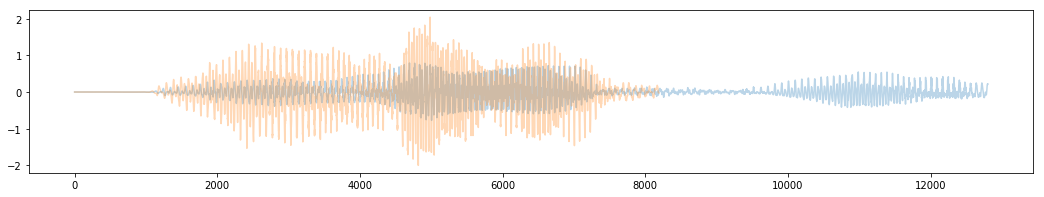

In [19]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

feed_dicts = {spect: np.expand_dims(specs[:32], axis=0)}
_audio_sample = sess.run(audio_sample, feed_dict=feed_dicts)
#_audio_sample = np.clip(_audio_sample, -1., 1.)
clear_output()

plt.figure(figsize=[18, 3])
plt.plot(waves, alpha=0.3)
plt.plot(_audio_sample[0], alpha=0.3)
plt.show()



In [17]:
import IPython.display as ipd
ipd.Audio(waves, rate=22050)


In [18]:
import IPython.display as ipd
ipd.Audio(_audio_sample[0], rate=22050)

In [20]:
converter = tf.contrib.lite.TFLiteConverter.from_session(sess, [spect], [audio_sample])
converter.post_training_quantize=True
tflite_model = converter.convert()
open("waveglow_lj.tflite", "wb").write(tflite_model)



INFO:tensorflow:Froze 641 variables.
INFO:tensorflow:Converted 641 variables to const ops.


289228592

In [41]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path="waveglow_lj.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'Placeholder', 'index': 0, 'shape': array([ 1, 32, 80], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'WaveGlow/Reshape_1', 'index': 3, 'shape': array([   1, 8192], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [37]:
import time

t = time.time()
# Test model on random input data.
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(specs[:32], axis=0))

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data.shape)
print(time.time() - t)


(1, 8192)
17.527267694473267


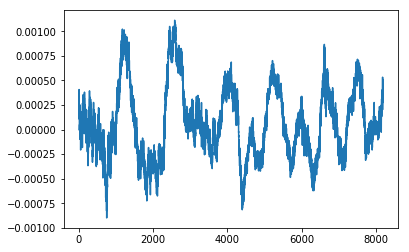

In [38]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt


plt.plot(output_data[0])
plt.show()

In [39]:
import IPython.display as ipd
ipd.Audio(output_data[0], rate=22050)
